https://www.codearmo.com/python-tutorial/options-trading-binomial-pricing-model

In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import yfinance as yf
import datetime as dt

# Creating the binomial tree

In [2]:
N = 4
S0  = 100
T = 0.5
sigma = 0.4
time = T/N
K =105
r = 0.05
u = np.exp( sigma * np.sqrt(time) )
d =  np.exp( -sigma * np.sqrt(time) )
p = ( np.exp(r*time) - d) / (u -d)

In [3]:
for k in reversed(range(N+1)):
    ST = S0 * u**k * d ** (N-k)
    print(round(ST,2), round(max(ST-K,0),2))

176.07 71.07
132.69 27.69
100.0 0
75.36 0
56.8 0


In [4]:
def combos(n, i):
    return math.factorial(n) / (math.factorial(n-i)*math.factorial(i))

In [5]:
for k in reversed(range(N+1)):
    p_star = combos(N, k)*p**k *(1-p)**(N-k)
    print(round(p_star,2))

0.06
0.24
0.37
0.26
0.07


#  Finding the value of the call

In [6]:
C=0   
for k in reversed(range(N+1)):
    p_star = combos(N, k)*p**k *(1-p)**(N-k)
    ST = S0 * u**k * d ** (N-k)
    C += max(ST-K,0)*p_star
    
print(np.exp(-r*T)*C)

10.287301121702995


In [7]:
def binom_EU1(S0, K , T, r, sigma, N, type_ = 'call'):
    time = T/N
    u = np.exp(sigma * np.sqrt(time))
    d = np.exp(-sigma * np.sqrt(time))
    p = (  np.exp(r*time) - d )  /  (  u - d )
    value = 0 
    for i in range(N+1):
        node_prob = combos(N, i)*p**i*(1-p)**(N-i)
        ST = S0*(u)**i*(d)**(N-i)
        if type_ == 'call':
            value += max(ST-K,0) * node_prob
        elif type_ == 'put':
            value += max(K-ST, 0)*node_prob
        else:
            raise ValueError("type_ must be 'call' or 'put'" )
    
    return value*np.exp(-r*T)

In [8]:
binom_EU1(S0, K, T, r,sigma, N)

10.287301121702995

In [9]:
Ns = [2, 4, 6, 8, 10, 20, 50, 100, 200, 300, 400,500, 600]
    

for n in Ns:
    c = binom_EU1(S0, K, T, r,sigma, n)
    print(f'Price is {n} steps is {round(c,2)}')

Price is 2 steps is 9.99
Price is 4 steps is 10.29
Price is 6 steps is 10.35
Price is 8 steps is 10.37
Price is 10 steps is 10.37
Price is 20 steps is 10.34
Price is 50 steps is 10.27
Price is 100 steps is 10.22
Price is 200 steps is 10.22
Price is 300 steps is 10.23
Price is 400 steps is 10.22
Price is 500 steps is 10.22
Price is 600 steps is 10.22


Text(0, 0.5, 'Stock Price')

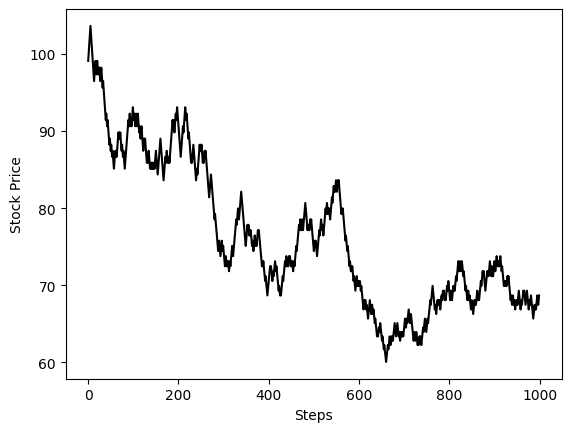

In [10]:
N=1000
sigma = 0.4
T = 0.5
K = 105
r= 0.05
time = T / N
Heads = np.exp(sigma * np.sqrt(time))
Tails = np.exp(-sigma * np.sqrt(time))
S0 = 100
p = (  np.exp(r*time) - Tails )  /  ( Heads - Tails )
paths = np.random.choice([Heads,Tails],p=[p,1-p],size=(N,1))
plt.plot(paths.cumprod(axis=0)*100, color='black');
plt.xlabel('Steps')
plt.ylabel('Stock Price')

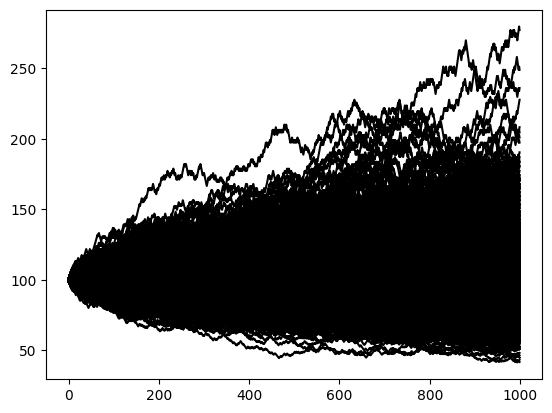

In [11]:
paths = np.random.choice([Heads,Tails],p=[p,1-p],size=(N,1000))
plt.plot(paths.cumprod(axis=0)*100, color='black');

# Pricing Real Options on Yahoo Finance

In [12]:
#Parameters

Stock="TSLA"
Lookback_period=5                   #Only consider options traded in the past x days
Minimum_impliedVolatility=0.005     #Only consider options above this implied volatility

In [13]:
def combos(n, i):
    return math.factorial(n) / (math.factorial(n-i)*math.factorial(i))

In [14]:
def binom_EU1(S0, K , T, r, sigma, N, type_ = 'Call'):
    time = T/N
    u = np.exp(sigma * np.sqrt(time))
    d = np.exp(-sigma * np.sqrt(time))
    p = (  np.exp(r*time) - d )  /  (  u - d )
    value = 0 
    for i in range(N+1):
        node_prob = combos(N, i)*p**i*(1-p)**(N-i)
        ST = S0*(u)**i*(d)**(N-i)
        if type_ == 'Call':
            value += max(ST-K,0) * node_prob
        elif type_ == 'Put':
            value += max(K-ST, 0)*node_prob
        else:
            raise ValueError("type_ must be 'call' or 'put'" )
    
    return value*np.exp(-r*T)


In [15]:
def fetch_option_data(ticker): 
    """
    Fetch option chain data for a given stock ticker. 
    """
    Ticker = yf.Ticker(ticker)
    expirations = Ticker.options
    
    option_data = pd.DataFrame() 
    
    for expiration in expirations:
        
        option_chain = Ticker.option_chain(expiration) 
        
        calls = option_chain.calls
        calls['Option_Type'] = "Call" 
        
        puts = option_chain.puts
        puts['Option_Type'] = "Put" 
        
        options = pd.concat([calls, puts])
        options['Expiration_Date'] = pd.to_datetime(expiration) + pd.DateOffset(hours=23, minutes=59, seconds=59)
        
        option_data = pd.concat([option_data, options])
    option_data["Days_to_Expiration"] = (option_data['Expiration_Date'] - dt.datetime.today()).dt.days + 1 
    
    return option_data

In [16]:
options_data = fetch_option_data(Stock)

In [17]:
dt.datetime.today()

datetime.datetime(2024, 8, 28, 23, 48, 34, 792433)

In [18]:
options_data

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Option_Type,Expiration_Date,Days_to_Expiration
0,TSLA240830C00075000,2024-08-27 15:35:29+00:00,75.0,134.18,129.70,130.75,0.0,0.0,1.0,14.0,3.781251,True,REGULAR,USD,Call,2024-08-30 23:59:59,3
1,TSLA240830C00080000,2024-08-26 14:38:50+00:00,80.0,131.80,124.70,125.75,0.0,0.0,1.0,1.0,3.562501,True,REGULAR,USD,Call,2024-08-30 23:59:59,3
2,TSLA240830C00085000,2024-08-21 14:38:28+00:00,85.0,137.00,119.70,120.90,0.0,0.0,2.0,2.0,4.195317,True,REGULAR,USD,Call,2024-08-30 23:59:59,3
3,TSLA240830C00090000,2024-08-23 15:55:23+00:00,90.0,128.42,114.65,115.75,0.0,0.0,10.0,10.0,3.125002,True,REGULAR,USD,Call,2024-08-30 23:59:59,3
4,TSLA240830C00095000,2024-08-02 18:34:55+00:00,95.0,113.95,109.70,110.85,0.0,0.0,1.0,1.0,3.546876,True,REGULAR,USD,Call,2024-08-30 23:59:59,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,TSLA261218P00500000,2024-08-05 13:47:35+00:00,500.0,306.39,295.95,297.40,0.0,0.0,1.0,200.0,0.349372,True,REGULAR,USD,Put,2026-12-18 23:59:59,843
71,TSLA261218P00510000,2024-07-24 14:54:43+00:00,510.0,294.26,290.65,296.60,0.0,0.0,1.0,20.0,0.000010,True,REGULAR,USD,Put,2026-12-18 23:59:59,843
72,TSLA261218P00520000,2024-08-13 14:06:08+00:00,520.0,315.05,315.20,316.45,0.0,0.0,1.0,36.0,0.337714,True,REGULAR,USD,Put,2026-12-18 23:59:59,843
73,TSLA261218P00530000,2024-08-23 18:00:37+00:00,530.0,313.04,324.85,326.10,0.0,0.0,2.0,13.0,0.333076,True,REGULAR,USD,Put,2026-12-18 23:59:59,843


In [19]:
#We need a filter for last trade date, say no more than 5 days
options_data["lastTradeDate"] = pd.to_datetime(options_data["lastTradeDate"]).dt.tz_localize(None)
options_data = options_data[options_data["lastTradeDate"] >= (dt.datetime.today() - dt.timedelta(days=Lookback_period))]

In [20]:
options_data

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Option_Type,Expiration_Date,Days_to_Expiration
0,TSLA240830C00075000,2024-08-27 15:35:29,75.0,134.18,129.70,130.75,0.000000,0.000000,1.0,14.0,3.781251,True,REGULAR,USD,Call,2024-08-30 23:59:59,3
1,TSLA240830C00080000,2024-08-26 14:38:50,80.0,131.80,124.70,125.75,0.000000,0.000000,1.0,1.0,3.562501,True,REGULAR,USD,Call,2024-08-30 23:59:59,3
5,TSLA240830C00100000,2024-08-26 18:58:33,100.0,113.74,104.70,105.75,0.000000,0.000000,1.0,69.0,2.750003,True,REGULAR,USD,Call,2024-08-30 23:59:59,3
7,TSLA240830C00110000,2024-08-28 13:45:42,110.0,97.50,94.65,95.80,-11.839996,-10.828605,3.0,21.0,2.742191,True,REGULAR,USD,Call,2024-08-30 23:59:59,3
8,TSLA240830C00115000,2024-08-27 15:48:11,115.0,94.03,89.60,90.80,0.000000,0.000000,2.0,2.0,2.562504,True,REGULAR,USD,Call,2024-08-30 23:59:59,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,TSLA261218P00340000,2024-08-26 13:45:16,340.0,147.35,153.40,154.45,0.000000,0.000000,20.0,127.0,0.420889,True,REGULAR,USD,Put,2026-12-18 23:59:59,843
55,TSLA261218P00350000,2024-08-27 17:28:42,350.0,159.10,161.70,162.75,0.000000,0.000000,2.0,142.0,0.417212,True,REGULAR,USD,Put,2026-12-18 23:59:59,843
57,TSLA261218P00370000,2024-08-26 14:48:55,370.0,174.47,178.50,179.55,0.000000,0.000000,4.0,53.0,0.408575,True,REGULAR,USD,Put,2026-12-18 23:59:59,843
58,TSLA261218P00380000,2024-08-28 13:56:02,380.0,185.41,187.00,187.95,9.260010,5.256889,1.0,405.0,0.402594,True,REGULAR,USD,Put,2026-12-18 23:59:59,843


In [21]:
# We need a filter for open interest, say more than 0
# options_data = options_data[options_data["openInterest"] > 0]

In [22]:
prices = [] 

for row in options_data.itertuples():
    price = binom_EU1(row.lastPrice, row.strike, row.Days_to_Expiration/252, 0.01, 0.5, 20, row.Option_Type)
    prices.append(price)

In [23]:
options_data['Price'] = prices
    
options_data['error'] = options_data.lastPrice - options_data.Price 

/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_99219/2904534803.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_data['Price'] = prices
/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_99219/2904534803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_data['error'] = options_data.lastPrice - options_data.Price


In [24]:
options_data

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Option_Type,Expiration_Date,Days_to_Expiration,Price,error
0,TSLA240830C00075000,2024-08-27 15:35:29,75.0,134.18,129.70,130.75,0.000000,0.000000,1.0,14.0,3.781251,True,REGULAR,USD,Call,2024-08-30 23:59:59,3,59.188928,74.991072
1,TSLA240830C00080000,2024-08-26 14:38:50,80.0,131.80,124.70,125.75,0.000000,0.000000,1.0,1.0,3.562501,True,REGULAR,USD,Call,2024-08-30 23:59:59,3,51.809523,79.990477
5,TSLA240830C00100000,2024-08-26 18:58:33,100.0,113.74,104.70,105.75,0.000000,0.000000,1.0,69.0,2.750003,True,REGULAR,USD,Call,2024-08-30 23:59:59,3,13.766850,99.973150
7,TSLA240830C00110000,2024-08-28 13:45:42,110.0,97.50,94.65,95.80,-11.839996,-10.828605,3.0,21.0,2.742191,True,REGULAR,USD,Call,2024-08-30 23:59:59,3,0.021786,97.478214
8,TSLA240830C00115000,2024-08-27 15:48:11,115.0,94.03,89.60,90.80,0.000000,0.000000,2.0,2.0,2.562504,True,REGULAR,USD,Call,2024-08-30 23:59:59,3,0.000041,94.029959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,TSLA261218P00340000,2024-08-26 13:45:16,340.0,147.35,153.40,154.45,0.000000,0.000000,20.0,127.0,0.420889,True,REGULAR,USD,Put,2026-12-18 23:59:59,843,200.565718,-53.215718
55,TSLA261218P00350000,2024-08-27 17:28:42,350.0,159.10,161.70,162.75,0.000000,0.000000,2.0,142.0,0.417212,True,REGULAR,USD,Put,2026-12-18 23:59:59,843,201.792709,-42.692709
57,TSLA261218P00370000,2024-08-26 14:48:55,370.0,174.47,178.50,179.55,0.000000,0.000000,4.0,53.0,0.408575,True,REGULAR,USD,Put,2026-12-18 23:59:59,843,209.758211,-35.288211
58,TSLA261218P00380000,2024-08-28 13:56:02,380.0,185.41,187.00,187.95,9.260010,5.256889,1.0,405.0,0.402594,True,REGULAR,USD,Put,2026-12-18 23:59:59,843,211.892494,-26.482494


In [25]:
options_data.Expiration_Date.unique()[2]

Timestamp('2024-09-13 23:59:59')

In [26]:
exp1 = options_data[(options_data.Expiration_Date == options_data.Expiration_Date.unique()[2]) & (options_data.Option_Type=='Call')]

In [27]:
exp1

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Option_Type,Expiration_Date,Days_to_Expiration,Price,error
0,TSLA240913C00095000,2024-08-28 14:46:54,95.0,111.33,110.00,110.85,-5.019997,-4.314565,4.0,5.0,1.488284,True,REGULAR,USD,Call,2024-09-13 23:59:59,17,17.108764,94.221236
3,TSLA240913C00115000,2024-08-28 14:15:09,115.0,92.90,90.00,90.90,-2.449997,-2.569478,5.0,6.0,1.199223,True,REGULAR,USD,Call,2024-09-13 23:59:59,17,0.284263,92.615737
7,TSLA240913C00140000,2024-08-27 17:26:36,140.0,67.35,65.10,66.05,-3.300003,-4.670917,5.0,16.0,0.913087,True,REGULAR,USD,Call,2024-09-13 23:59:59,17,0.000000,67.350000
8,TSLA240913C00145000,2024-08-28 15:26:58,145.0,60.70,60.55,60.75,-4.399998,-6.758829,45.0,79.0,0.585942,True,REGULAR,USD,Call,2024-09-13 23:59:59,17,0.000000,60.700000
9,TSLA240913C00150000,2024-08-28 15:20:17,150.0,55.44,55.80,55.95,-4.610001,-7.676937,48.0,104.0,0.680667,True,REGULAR,USD,Call,2024-09-13 23:59:59,17,0.000000,55.440000
10,TSLA240913C00155000,2024-08-28 15:26:34,155.0,50.60,50.90,51.05,-4.960003,-8.927291,64.0,90.0,0.669925,True,REGULAR,USD,Call,2024-09-13 23:59:59,17,0.000000,50.600000
11,TSLA240913C00160000,2024-08-28 15:20:17,160.0,45.60,45.80,45.95,-5.060001,-9.988159,35.0,120.0,0.556645,True,REGULAR,USD,Call,2024-09-13 23:59:59,17,0.000000,45.600000
12,TSLA240913C00165000,2024-08-28 15:29:00,165.0,41.15,41.00,41.15,-4.849998,-10.543475,56.0,53.0,0.575200,True,REGULAR,USD,Call,2024-09-13 23:59:59,17,0.000000,41.150000
13,TSLA240913C00170000,2024-08-28 15:12:30,170.0,35.75,36.30,36.50,-5.000000,-12.269938,69.0,63.0,0.583989,True,REGULAR,USD,Call,2024-09-13 23:59:59,17,0.000000,35.750000
14,TSLA240913C00175000,2024-08-28 15:11:28,175.0,31.19,31.60,31.75,-4.609999,-12.877091,37.0,181.0,0.557622,True,REGULAR,USD,Call,2024-09-13 23:59:59,17,0.000000,31.190000


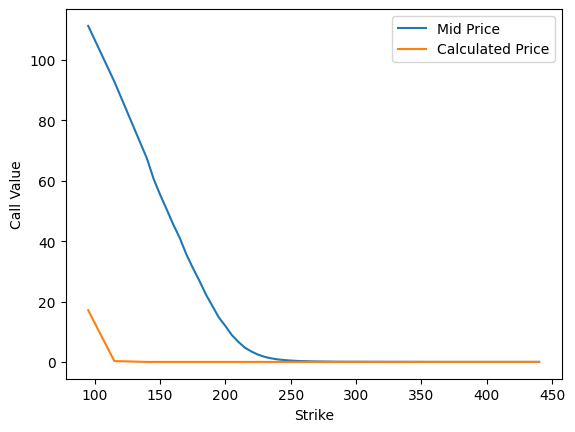

In [28]:
plt.plot(exp1.strike, exp1.lastPrice,label= 'Mid Price')
plt.plot(exp1.strike, exp1.Price, label = 'Calculated Price')
plt.xlabel('Strike')
plt.ylabel('Call Value')
plt.legend()

# The below cells do the same thing, but allows more control over Ticker, Expiration Date

In [29]:
# This cell gets all the available expirations for a ticker

stock = yf.Ticker("TSLA")
expirations = stock.options
expirations

('2024-08-30',
 '2024-09-06',
 '2024-09-13',
 '2024-09-20',
 '2024-09-27',
 '2024-10-04',
 '2024-10-18',
 '2024-11-15',
 '2024-12-20',
 '2025-01-17',
 '2025-02-21',
 '2025-03-21',
 '2025-06-20',
 '2025-08-15',
 '2025-09-19',
 '2025-12-19',
 '2026-01-16',
 '2026-06-18',
 '2026-12-18')

In [30]:
# This cell gets all the options expiring on a certain date for that ticker

option_chain = stock.option_chain(expirations[1])    #Second most immediate date
option_chain

Options(calls=         contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0   TSLA240906C00075000 2024-08-27 15:05:25+00:00    75.0     135.05  129.85   
1   TSLA240906C00080000 2024-08-27 15:33:51+00:00    80.0     128.75  124.90   
2   TSLA240906C00095000 2024-08-22 14:28:49+00:00    95.0     126.01  110.00   
3   TSLA240906C00100000 2024-08-27 14:48:06+00:00   100.0     110.05  105.00   
4   TSLA240906C00115000 2024-08-15 15:51:49+00:00   115.0      99.45   90.05   
..                  ...                       ...     ...        ...     ...   
72  TSLA240906C00400000 2024-08-20 14:16:32+00:00   400.0       0.02    0.00   
73  TSLA240906C00410000 2024-08-26 15:05:51+00:00   410.0       0.01    0.00   
74  TSLA240906C00420000 2024-08-22 13:30:00+00:00   420.0       0.01    0.00   
75  TSLA240906C00430000 2024-08-26 16:19:27+00:00   430.0       0.01    0.00   
76  TSLA240906C00440000 2024-08-28 14:10:23+00:00   440.0       0.01    0.00   

       ask  change  perce

In [31]:
calls = option_chain.calls
calls['Option_Type'] = "Call" 

In [32]:
calls['Expiration_Date'] = pd.to_datetime(expirations[1]) + pd.DateOffset(hours=23, minutes=59, seconds=59)

In [33]:
calls["Days_to_Expiration"] = (calls['Expiration_Date'] - dt.datetime.today()).dt.days + 1 

In [34]:
calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Option_Type,Expiration_Date,Days_to_Expiration
0,TSLA240906C00075000,2024-08-27 15:05:25+00:00,75.0,135.05,129.85,130.65,0.0,0.0,1,1,0.000010,True,REGULAR,USD,Call,2024-09-06 23:59:59,10
1,TSLA240906C00080000,2024-08-27 15:33:51+00:00,80.0,128.75,124.90,125.70,0.0,0.0,4,6,0.000010,True,REGULAR,USD,Call,2024-09-06 23:59:59,10
2,TSLA240906C00095000,2024-08-22 14:28:49+00:00,95.0,126.01,110.00,110.85,0.0,0.0,4,4,1.941407,True,REGULAR,USD,Call,2024-09-06 23:59:59,10
3,TSLA240906C00100000,2024-08-27 14:48:06+00:00,100.0,110.05,105.00,105.85,0.0,0.0,2,10,1.824220,True,REGULAR,USD,Call,2024-09-06 23:59:59,10
4,TSLA240906C00115000,2024-08-15 15:51:49+00:00,115.0,99.45,90.05,90.90,0.0,0.0,2,2,1.564455,True,REGULAR,USD,Call,2024-09-06 23:59:59,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,TSLA240906C00400000,2024-08-20 14:16:32+00:00,400.0,0.02,0.00,0.01,0.0,0.0,100,228,1.187504,False,REGULAR,USD,Call,2024-09-06 23:59:59,10
73,TSLA240906C00410000,2024-08-26 15:05:51+00:00,410.0,0.01,0.00,0.01,0.0,0.0,10,48,1.218754,False,REGULAR,USD,Call,2024-09-06 23:59:59,10
74,TSLA240906C00420000,2024-08-22 13:30:00+00:00,420.0,0.01,0.00,0.01,0.0,0.0,1,12,1.250004,False,REGULAR,USD,Call,2024-09-06 23:59:59,10
75,TSLA240906C00430000,2024-08-26 16:19:27+00:00,430.0,0.01,0.00,0.01,0.0,0.0,4,5,1.312503,False,REGULAR,USD,Call,2024-09-06 23:59:59,10


In [35]:
prices = [] 

for row in calls.itertuples():
    price = binom_EU1(row.lastPrice, row.strike, row.Days_to_Expiration/252, 0.01, 0.5, 20, row.Option_Type)
    prices.append(price)

In [36]:
calls['Price'] = prices
    
calls['error'] = calls.lastPrice - calls.Price 

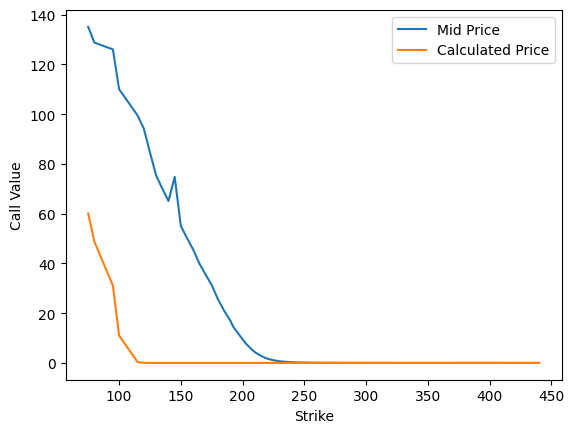

In [37]:
plt.plot(calls.strike, calls.lastPrice,label= 'Mid Price')
plt.plot(calls.strike, calls.Price, label = 'Calculated Price')
plt.xlabel('Strike')
plt.ylabel('Call Value')
plt.legend()
